In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [123]:
rows_interval = 4
rows_min = rows_interval
rows_max = 16
rows = int(rows_max/rows_interval) - int(rows_min/rows_interval) + 1

row_space = list(range(rows_min, rows_max + 1, rows_interval))
scalar_space = [1000, 10000, 100000]

columns = 3

ns_conversion_factor = 1e-9 # ns to s
gb_conversion_factor = 1e-6 # kb to gb

In [124]:
def array_operation(median_array_op_prec, op, prec):
    for i, n in enumerate(row_space):
        for j, m in enumerate([n*scalar for scalar in scalar_space]):
            try:
                directoryname = f"../blas_results/gemm_{op}_{prec}/{n}_{m}"
                filename = "results.csv"
                df = pd.read_csv(f"{directoryname}/{filename}", usecols=["BeginNs", "EndNs"])
                subtracted_df = df["EndNs"] - df["BeginNs"]
                # subtracted_array = subtracted_df.to_numpy()
                # median_execution_time = np.median(subtracted_array) * ns_conversion_factor

                filename = "events.csv"
                df = pd.read_csv(f"{directoryname}/{filename}", usecols=["FETCH_SIZE", "WRITE_SIZE"])
                kilobyte_sum = df["FETCH_SIZE"] + df["WRITE_SIZE"]
                bandwidth_df = kilobyte_sum * gb_conversion_factor / (subtracted_df * ns_conversion_factor)
                # kilobyte_sum = df["FETCH_SIZE"][1]
                # kilobyte_sum = df["FETCH_SIZE"][0] + df["WRITE_SIZE"][0] - df["FETCH_SIZE"][1]
                median_array_op_prec[i, j] = np.median(bandwidth_df.to_numpy())
            except:
                print(n,m)

In [125]:
median_arrays = []
for precision in [32, 64]:
    for operation in ["op_n", "op_t"]:
        median_arrays.append(np.zeros((rows, columns)))
        array_operation(median_arrays[-1], operation, precision)

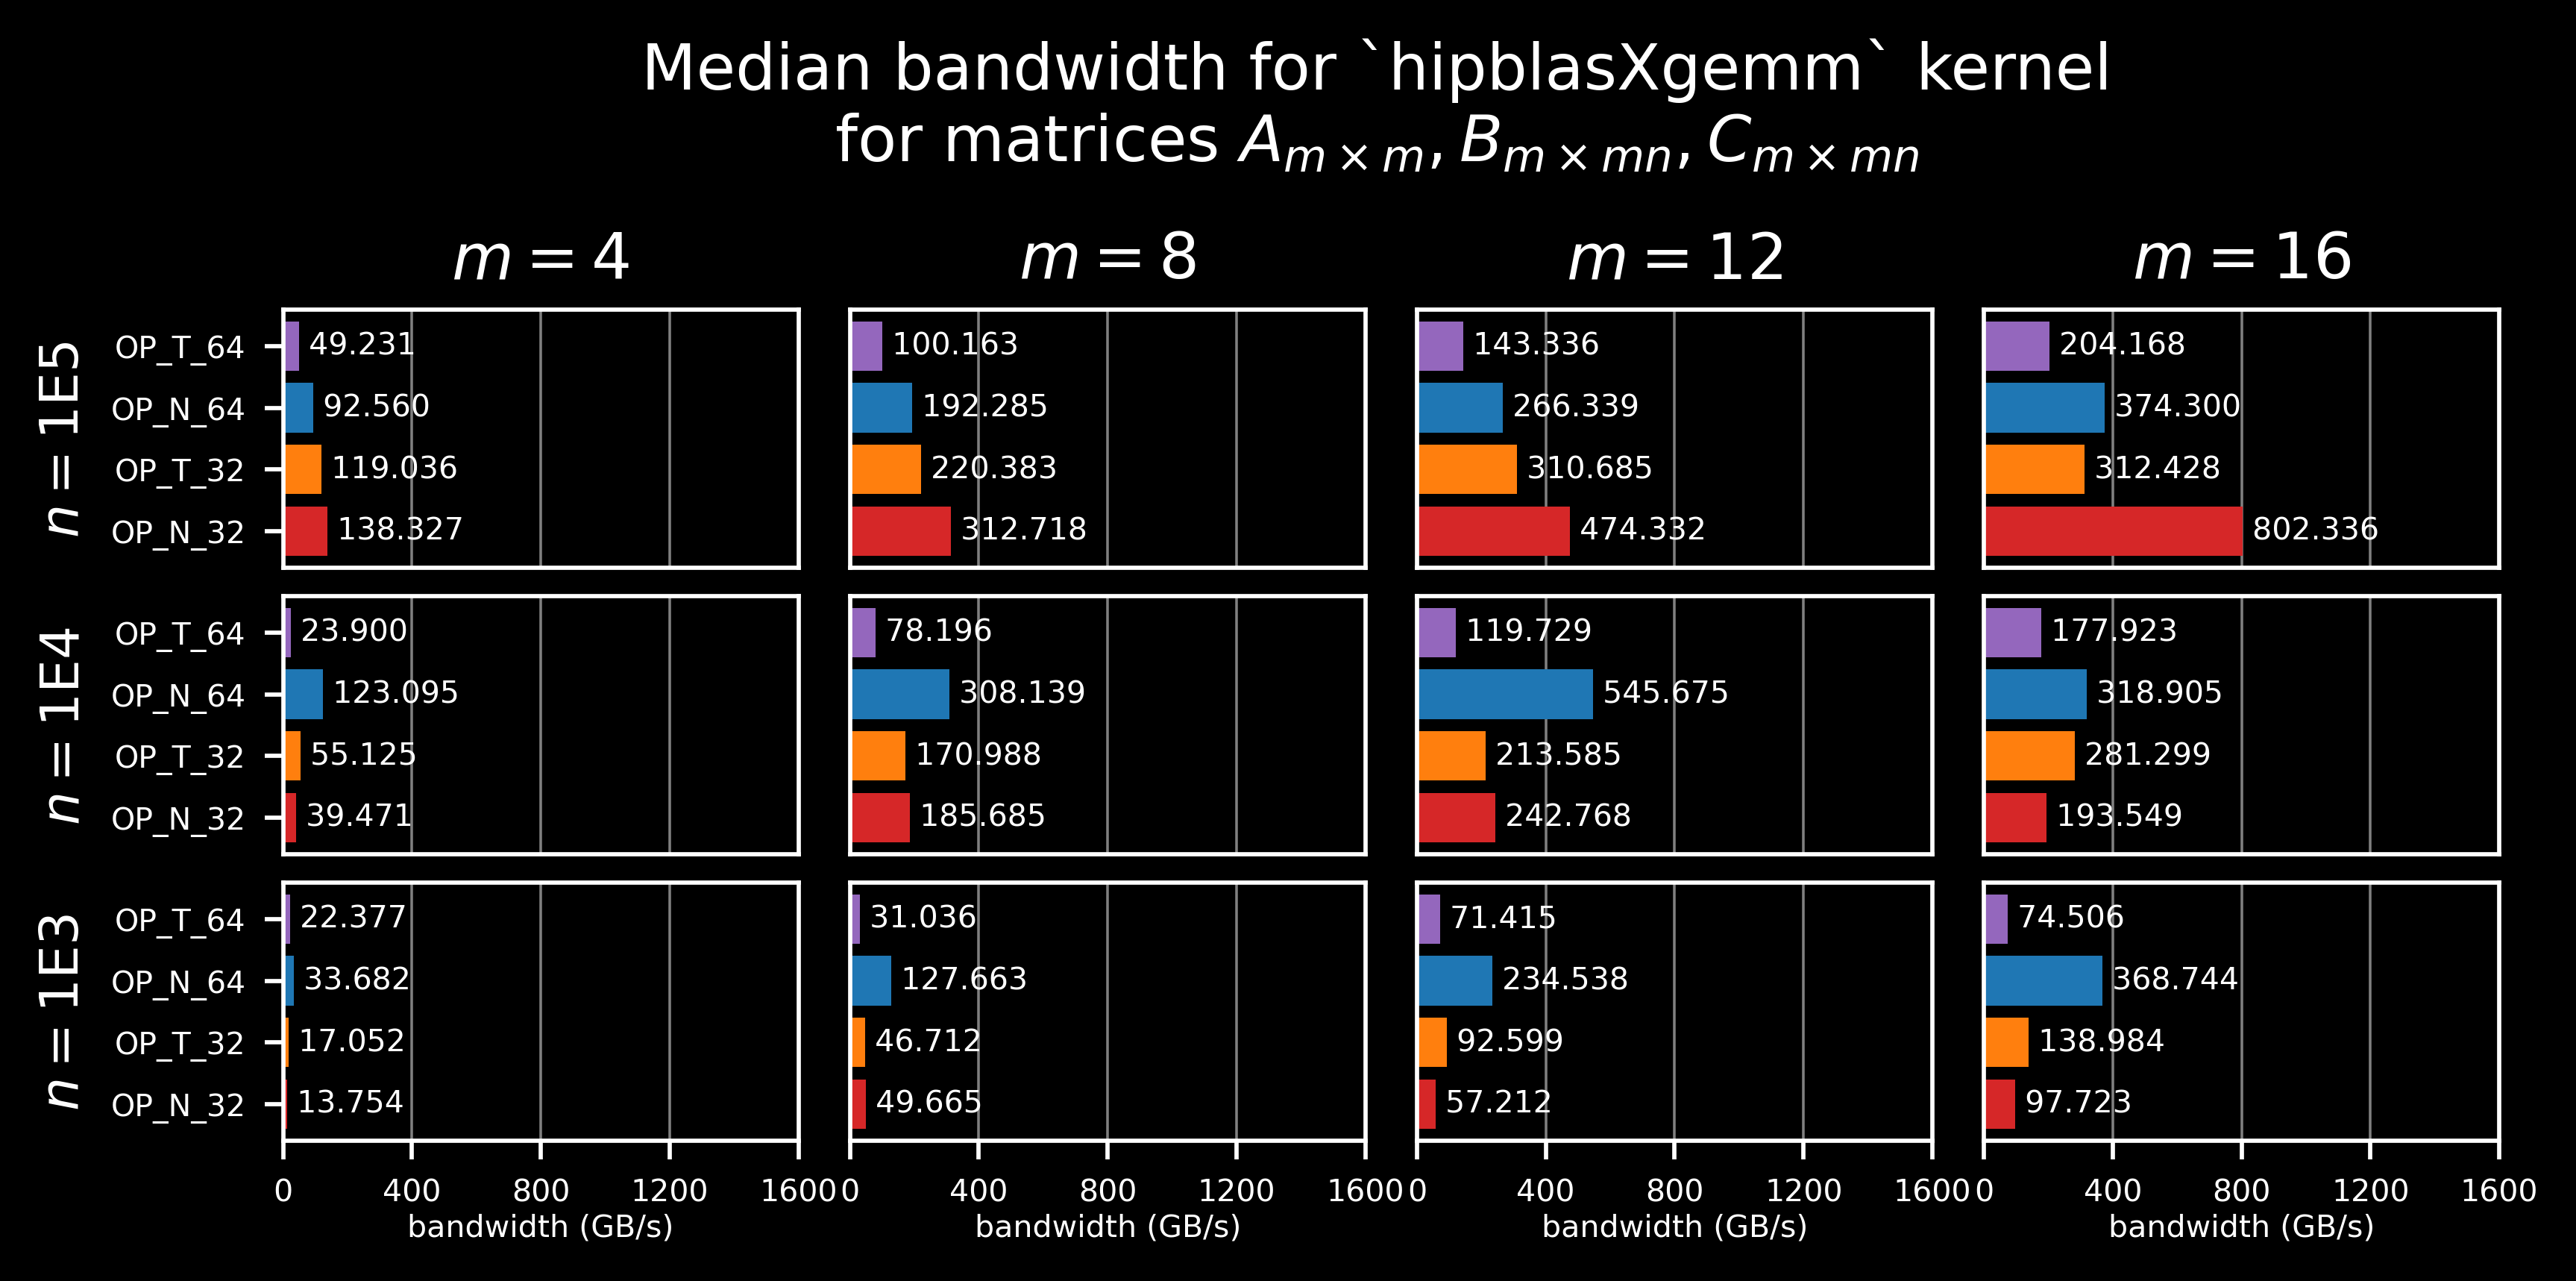

In [126]:
import matplotlib.patches as mpatches
plt.style.use('dark_background')

titles = ["OP_N_32", "OP_T_32", "OP_N_64", "OP_T_64"]

fig, axes = plt.subplots(
    median_arrays[0].shape[1],
    median_arrays[0].shape[0], 
    subplot_kw=dict(box_aspect=1/2),
    sharex=True,
    sharey=True,
    #layout="constrained",
    dpi=512,
)
fig.tight_layout()

custom_wspace=0.1
custom_hspace=-0.75
plt.subplots_adjust(wspace=custom_wspace, hspace=custom_hspace)

y_pos = np.arange(median_arrays[0].shape[0])
width = 0.25

bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:purple']
xlim = 1600 # 1.6TB/s peak performance for MI210

# Row labels
for i in range(median_arrays[0].shape[1]):
    k = median_arrays[0].shape[1] - i + 2
    axes[i, 0].set_ylabel(
        fr"$n=1\mathrm{{E}}{k}$",
        fontsize="medium",
        #weight="bold",
    )

for i, m in enumerate(row_space):
    for j, m_scalar in enumerate(scalar_space):
        ax = axes[len(scalar_space) - j - 1,i]
        ax.set_axisbelow(True)
        ms = [median_array[i][j] for median_array in median_arrays]
        rects = ax.barh(titles, ms, label=titles, color=bar_colors)
        ax.grid(which="both", axis="x", linewidth='0.5', color="grey")
        ax.set_xlim(0, xlim)
        ax.set_xticks(range(0,xlim+1, int(xlim/4)))
        ax.set_xticklabels(
            range(0,xlim+1, int(xlim/4)),
            fontsize="xx-small",
        )
        ax.set_yticks(
            ticks=y_pos,
            labels=titles,
            minor=False,
            fontsize="xx-small",
        )
        # Add column units (bottom)
        if j == 0:
            ax.set_xlabel(
                "bandwidth (GB/s)",
                fontsize="xx-small",
            )
            ax.xaxis.set_label_coords(0.5, 0.375*custom_hspace)
        else:
            ax.xaxis.set_ticks_position('none') 
        # Add column labels (top)
        if j == median_arrays[0].shape[1] - 1:
            ax.set_xlabel(
                fr"$m = {row_space[i]}$",
                position=(0.5,0.0),
                fontsize="large",
            )
            ax.xaxis.set_label_coords(0.5, -1.75*custom_hspace)
        if i > 0:
            ax.yaxis.set_ticks_position('none') 
            
        for y in y_pos:
            if True:
                ax.text(
                    ms[y], 
                    y, 
                    f" {ms[y]:.3f}", 
                    ha="left", 
                    va="center", 
                    fontsize="xx-small",
                    #bbox=dict(facecolor='black', edgecolor='none', pad=0.01)
                )
            else:
                ax.text(
                    ms[y], 
                    y, 
                    f"{ms[y]:.3f} ", 
                    ha="right", 
                    va="center", 
                    fontsize="xx-small",
                )

fig.suptitle(
    "Median bandwidth for `hipblasXgemm` kernel" + '\n' + r"for matrices $A_{m \times m}, B_{m \times mn}, C_{m \times mn}$", 
    x=0.5, 
    y=0.875
)

plt.show()